In [574]:
import numpy as np
import pandas   as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import set_config
#set_config(transform_output='pandas')

# Data mpg

In [575]:
df = sns.load_dataset('mpg')
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite


1. Éliminer les lignes contenant des valeurs manquantes

In [576]:
df.isna().sum(), df.shape

(mpg             0
 cylinders       0
 displacement    0
 horsepower      6
 weight          0
 acceleration    0
 model_year      0
 origin          0
 name            0
 dtype: int64,
 (398, 9))

In [577]:
# suppression des valeurs manquantes
df.dropna(axis=0, inplace=True)


2. Extraire le constructeur automobile de la variable name et mettre le résultat dans une variable "constructor" (si vous l'ignorez, mettez "other"), puis éliminer la colonne "name"

In [578]:
from collections import Counter

In [579]:
# Récuperation de tout les mots dans les noms des voitures
all_words = " ".join(df['name']).split()

# Nombre d'occurence des mots
count_words = Counter(all_words)

# Filtre des mots les plus fréquent > 3
repeated_words = {word : count for word, count in count_words.items() if count >4}

print(repeated_words)

{'chevrolet': 43, 'chevelle': 6, 'malibu': 8, 'buick': 17, 'plymouth': 31, 'amc': 27, 'ford': 48, 'torino': 7, 'fury': 6, 'pontiac': 16, 'dodge': 28, '(sw)': 28, 'toyota': 25, 'corona': 8, 'ii': 7, 'hornet': 5, 'datsun': 23, 'volkswagen': 15, 'peugeot': 8, '504': 5, 'audi': 7, 'vega': 5, 'custom': 18, 'matador': 7, 'brougham': 10, 'mercury': 11, 'opel': 5, 'fiat': 8, 'corolla': 10, 'colt': 7, 'pinto': 7, 'oldsmobile': 10, 'chrysler': 6, 'mazda': 10, 'coupe': 5, 'gran': 6, 'volvo': 6, 'century': 6, 'classic': 6, 'honda': 13, 'civic': 8, 'rabbit': 10, 'vw': 6, 'cutlass': 5, 'glc': 6, 'fairmont': 5}


In [580]:
# Liste des constructeurs automobile
ConstructorList = [
    'chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac', 'dodge', 'toyota', 'datsun',
    'volkswagen','peugeot', 'audi', 'opel', 'fiat', 'oldsmobile', 'chrysler', 'mazda', 'volvo', 'honda',
    'vw',  'bmw', 'saab', 'renault', 'subaru', 'mercedes-benz', 'nissan', 'cadillac', 'mercury'
]

# mapping des alias
alias_mapping = {
    'vw': 'volkswagen',
    'vokswagen': 'volkswagen', 
    'mercedes benz': 'mercedes-benz',
    'maxda': 'mazda',
    'toyouta': 'toyota',
    'chevroelt':'chevrolet',
    'capri': 'mercury'
}

In [581]:
# fonction pour trouver les marques des voitures
def find_brand(name):
    name = name.lower()
    for alias,  mapping in alias_mapping.items():
        if alias in name: 
           return mapping

    for constructor in ConstructorList:
        if constructor in  name:
            return  constructor
        
    return 'other'    

In [582]:
df['brand'] = df['name'].apply(find_brand)

In [583]:
df_brand = df.drop(columns='name')
df_brand.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,brand
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford


In [584]:
# index des marques non connues
index = df_brand.query("`brand` == 'other' ").index
index = list(index)
df.loc[index]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,brand
26,10.0,8,307.0,200.0,4376,15.0,70,usa,chevy c20,other
28,9.0,8,304.0,193.0,4732,18.5,70,usa,hi 1200d,other
213,13.0,8,350.0,145.0,4055,12.0,76,usa,chevy c10,other
335,35.0,4,122.0,88.0,2500,15.1,80,europe,triumph tr7 coupe,other
397,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy s-10,other


3. Séparer le jeu de données en X/y (y est la variable mpg et X tout le reste)

In [585]:
X = df_brand.drop(columns='mpg')
y = df_brand['mpg']

4. Séparer le jeu de données en trainset et testset (en écrivant `train_test_split(X, y)`)

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [587]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 8), (79, 8), (313,), (79,))


5. Encoder les catégories de la maniere la plus pertinente

In [588]:
ordinal_col = ['brand']
categorical_col = ['origin']
discret_col = ['model_year', 'cylinders']
continue_col = ['horsepowers', 'acceleration', 'displacement', 'weight']

ordinal = OrdinalEncoder()
OneHot = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

set_config(transform_output='pandas')


6. Utiliser un Polynomial Feature de degré 2 sur les variables Acceleration, Horsepower et weight

In [589]:
Polynomial_col = ['horsepower', 'acceleration', 'weight']
Polynomial_Feature = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

columnTransformer = ColumnTransformer(remainder='passthrough',
                                      verbose_feature_names_out=False,
                                      transformers=[
                                            ('category', OneHot, categorical_col),
                                            ('ordinal', ordinal, ordinal_col),
                                            ('Polynomial', Polynomial_Feature, Polynomial_col)
                                        ])
columnTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('category',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['origin']),
                                ('ordinal', OrdinalEncoder(), ['brand']),
                                ('Polynomial',
                                 PolynomialFeatures(include_bias=False,
                                                    interaction_only=True),
                                 ['horsepower', 'acceleration', 'weight'])],
                  verbose_feature_names_out=False)

In [590]:
X_train_tmp0 = X_train.copy()
X_train_tmp0_out = columnTransformer.fit_transform(X_train_tmp0)
X_train_tmp0_out.head(3)

,origin_japan,origin_usa,brand,horsepower,acceleration,weight,horsepower acceleration,horsepower weight,acceleration weight,cylinders,displacement,model_year
220,1.0,0.0,7.0,70.0,16.8,1945.0,1176.0,136150.0,32676.0,4,85.0,77
256,0.0,1.0,20.0,100.0,17.2,3430.0,1720.0,343000.0,58996.0,6,225.0,78
301,0.0,1.0,20.0,70.0,13.2,2200.0,924.0,154000.0,29040.0,4,105.0,79


In [591]:
X_train_tmp0_out.columns

Index(['origin_japan', 'origin_usa', 'brand', 'horsepower', 'acceleration',
       'weight', 'horsepower acceleration', 'horsepower weight',
       'acceleration weight', 'cylinders', 'displacement', 'model_year'],
      dtype='object')


7. Normaliser les variables cylinders, model_year, usa, et constructeur avec MinMaxScaler, et les autres variables avec un StandardScaler

In [592]:
MinMax_col = ['cylinders','model_year']
Standard_col = [ 'horsepower', 'acceleration','weight', 'horsepower acceleration','horsepower weight', 'acceleration weight', 'displacement', ]
normaliser = ColumnTransformer(remainder='passthrough',
                               verbose_feature_names_out=False,
                               transformers=[
                                    ('MinMax', MinMaxScaler(), MinMax_col ),
                                    ('Standard', StandardScaler(), Standard_col )
                               ])
normaliser

ColumnTransformer(remainder='passthrough',
                  transformers=[('MinMax', MinMaxScaler(),
                                 ['cylinders', 'model_year']),
                                ('Standard', StandardScaler(),
                                 ['horsepower', 'acceleration', 'weight',
                                  'horsepower acceleration',
                                  'horsepower weight', 'acceleration weight',
                                  'displacement'])],
                  verbose_feature_names_out=False)

In [593]:
X_train_tmp1 = X_train.copy()
pipeline1 = make_pipeline(columnTransformer, normaliser)
X_train_tmp1_out = pipeline1.fit_transform(X_train_tmp1)
X_train_tmp1_out.head(3)

,cylinders,model_year,horsepower,acceleration,weight,horsepower acceleration,horsepower weight,acceleration weight,displacement,origin_japan,origin_usa,brand
220,0.2,0.583333,-0.898424,0.445741,-1.223229,-0.940398,-0.923153,-1.030761,-1.046114,1.0,0.0,7.0
256,0.6,0.666667,-0.105920,0.589573,0.545070,0.434730,0.030537,1.107089,0.312633,0.0,1.0,20.0
301,0.2,0.750000,-0.898424,-0.848747,-0.919582,-1.577406,-0.840855,-1.326097,-0.852007,0.0,1.0,20.0


In [594]:
X_train_visual = X_train_tmp1_out

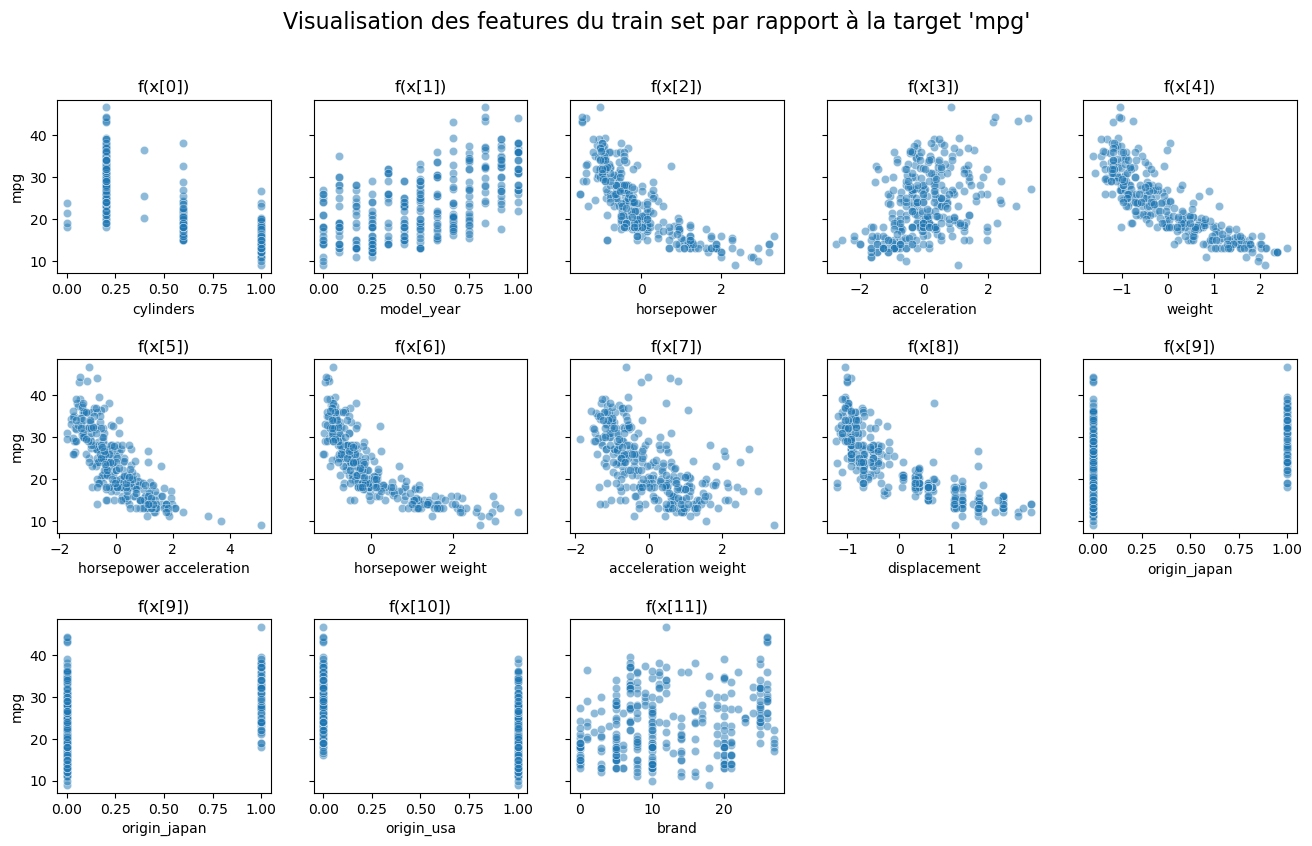

In [595]:
fig, ax = plt.subplots(3, 5, figsize=(16,9), sharey=True)
plt.suptitle("Visualisation des features du train set par rapport à la target 'mpg'", fontsize=16)

for i in range(0,5):
    sns.scatterplot(x=X_train_visual.iloc[:,i], y=y_train, ax=ax[0,i], alpha=0.5)
    ax[0,i].set_title(f"f(x[{i}])")
    ax[0,i].set_xlabel(f"{X_train_visual.columns[i]}")
    ax[0,i].set_ylabel("mpg")
for i in range(5,10):
    sns.scatterplot(x=X_train_visual.iloc[:,i], y=y_train, ax=ax[1,i-5], alpha=0.5)
    ax[1,i-5].set_title(f"f(x[{i}])")
    ax[1,i-5].set_xlabel(f"{X_train_visual.columns[i]}")
    ax[1,i-5].set_ylabel("mpg")
for i in range(9,12):
    sns.scatterplot(x=X_train_visual.iloc[:,i], y=y_train, ax=ax[2,i-9], alpha=0.5)
    ax[2,i-9].set_title(f"f(x[{i}])")
    ax[2,i-9].set_xlabel(f"{X_train_visual.columns[i]}")
    ax[2,i-9].set_ylabel("mpg")
    
fig.delaxes(ax[2, 3])  # Supprime les axes vides
fig.delaxes(ax[2, 4])
    
plt.subplots_adjust(hspace=0.5)
plt.show()


8. Utiliser un selectKBest avec k=10 sur l'ensemble de vos variables

In [596]:
SelectBest = make_pipeline(SelectKBest(score_func=f_regression, k=10))
SelectKBest

sklearn.feature_selection._univariate_selection.SelectKBest


9. Dessiner un diagramme de votre pipeline

In [597]:
pipeline = Pipeline(steps=[
                ('Encoder', columnTransformer),
                ('Normalisation', normaliser),
                ('Select Best feature', SelectBest)
            ])
pipeline

c:\Users\dalko\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['origin']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['brand']),
                                                 ('Polynomial',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['horsepower', 'acceleration',
                                                   'weight'])],
                                   verbose_feature_...
                                   transformers=[('MinMax', MinMaxScaler(),
                                                  ['cylinders', 'model_year']),
                                                 ('Standard', StandardScaler(),
                                                  ['horsepower', 'acceleration',
                                                   'weight',
                                                   'horsepower acceleration',
                                                   'horsepower weight',
                                                   'acceleration weight',
                                                   'displacement'])],
                                   verbose_feature_names_out=False)),
                ('Select Best feature',
                 Pipeline(steps=[('selectkbest',
                                  SelectKBest(score_func=<function f_regression at 0x0000026C96F5CA40>))]))])

In [598]:
X_train_selected = pipeline.fit_transform(X_train, y_train)
X_train_selected.head(3)

,cylinders,model_year,horsepower,weight,horsepower acceleration,horsepower weight,acceleration weight,displacement,origin_japan,origin_usa
220,0.2,0.583333,-0.898424,-1.223229,-0.940398,-0.923153,-1.030761,-1.046114,1.0,0.0
256,0.6,0.666667,-0.105920,0.545070,0.434730,0.030537,1.107089,0.312633,0.0,1.0
301,0.2,0.750000,-0.898424,-0.919582,-1.577406,-0.840855,-1.326097,-0.852007,0.0,1.0


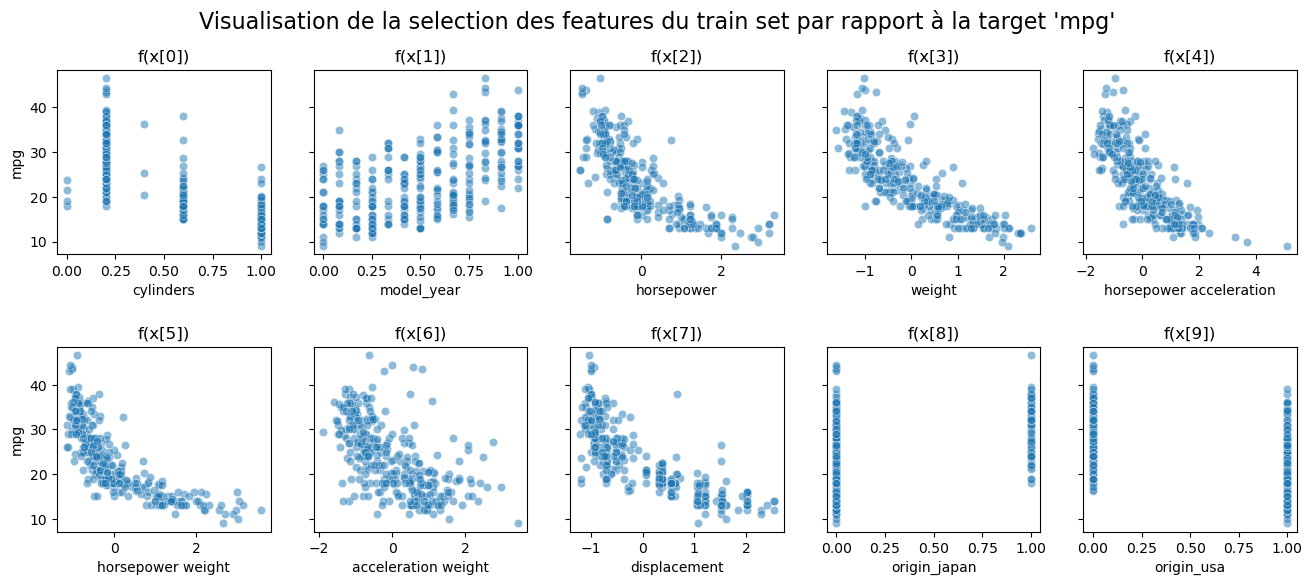

In [599]:
fig, ax = plt.subplots(2, 5, figsize=(16,6), sharey=True)
plt.suptitle("Visualisation de la selection des features du train set par rapport à la target 'mpg'", fontsize=16)

for i in range(0,5):
    sns.scatterplot(x=X_train_selected.iloc[:,i], y=y_train, ax=ax[0,i], alpha=0.5)
    ax[0,i].set_title(f"f(x[{i}])")
    ax[0,i].set_xlabel(f"{X_train_selected.columns[i]}")
    ax[0,i].set_ylabel("mpg")
for i in range(5,10):
    sns.scatterplot(x=X_train_selected.iloc[:,i], y=y_train, ax=ax[1,i-5], alpha=0.5)
    ax[1,i-5].set_title(f"f(x[{i}])")
    ax[1,i-5].set_xlabel(f"{X_train_selected.columns[i]}")
    ax[1,i-5].set_ylabel("mpg")
    
plt.subplots_adjust(hspace=0.5)
plt.show()


10. Mettre le tout dans une pipeline.
-   Déja fait en question 9

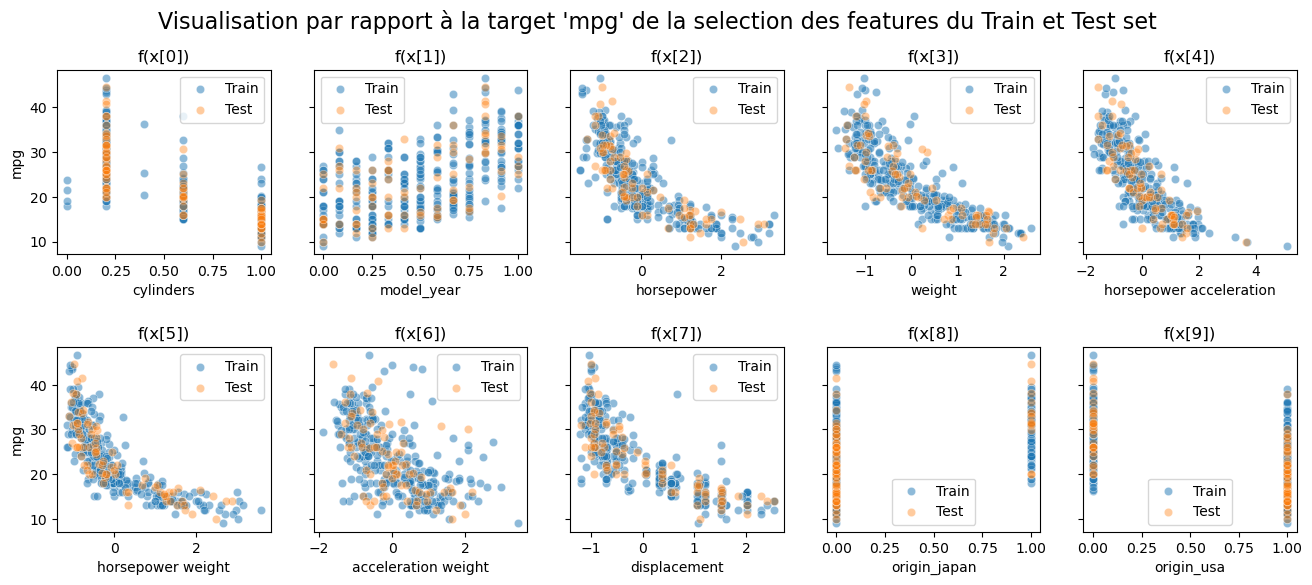

In [600]:
X_test_selected = pipeline.transform(X_test)


fig, ax = plt.subplots(2, 5, figsize=(16,6), sharey=True)
plt.suptitle("Visualisation par rapport à la target 'mpg' de la selection des features du Train et Test set", fontsize=16)

for i in range(0,5):
    sns.scatterplot(x=X_train_selected.iloc[:,i], y=y_train, ax=ax[0,i], alpha=0.5, label="Train")
    sns.scatterplot(x=X_test_selected.iloc[:,i], y=y_test, ax=ax[0,i], alpha=0.4, label="Test")
    ax[0,i].set_title(f"f(x[{i}])")
    ax[0,i].set_xlabel(f"{X_train_selected.columns[i]}")
    ax[0,i].set_ylabel("mpg")
for i in range(5,10):
    sns.scatterplot(x=X_train_selected.iloc[:,i], y=y_train, ax=ax[1,i-5], alpha=0.5, label="Train")
    sns.scatterplot(x=X_test_selected.iloc[:,i], y=y_test, ax=ax[1,i-5], alpha=0.4, label="Test")
    ax[1,i-5].set_title(f"f(x[{i}])")
    ax[1,i-5].set_xlabel(f"{X_train_selected.columns[i]}")
    ax[1,i-5].set_ylabel("mpg")
    
plt.subplots_adjust(hspace=0.5)
plt.show()